In [1]:
import torch
torch.__version__
from torch.nn import Linear
import pandas as pd

In [2]:

!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cu116.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.9/873.9 KB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 26.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 28.0 MB/s eta 0:00:00
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=6824a250ca47b86b6f8b71db9136eee911ec0f51456bb4fe36efda58825d9f12
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c65378
Successfully built torch-geometric
  

In [3]:
from typing import Tuple, Optional, Union
from torch import Tensor
from torch.nn import Parameter
import torch.nn as nn
from torch_scatter import scatter_add
from torch_sparse import SparseTensor, matmul, fill_diag, sum, mul_
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import add_remaining_self_loops
from torch_geometric.utils.num_nodes import maybe_num_nodes

from torch_geometric.nn.inits import glorot, zeros

Adj = Union[Tensor, SparseTensor]
OptTensor = Optional[Tensor]
PairTensor = Tuple[Tensor, Tensor]
OptPairTensor = Tuple[Tensor, Optional[Tensor]]
PairOptTensor = Tuple[Optional[Tensor], Optional[Tensor]]
Size = Optional[Tuple[int, int]]
NoneType = Optional[Tensor]


@torch.jit._overload
def gcn_norm(edge_index, edge_weight=None, num_nodes=None, improved=False,
             add_self_loops=True, dtype=None):
    # type: (Tensor, OptTensor, Optional[int], bool, bool, Optional[int]) -> PairTensor  # noqa
    pass


@torch.jit._overload
def gcn_norm(edge_index, edge_weight=None, num_nodes=None, improved=False,
             add_self_loops=True, dtype=None):
    # type: (SparseTensor, OptTensor, Optional[int], bool, bool, Optional[int]) -> SparseTensor  # noqa
    pass


def gcn_norm(edge_index, edge_weight=None, num_nodes=None, improved=False,
             add_self_loops=True, dtype=None):

    fill_value = 2. if improved else 1.

    if isinstance(edge_index, SparseTensor):
        adj_t = edge_index
        if not adj_t.has_value():
            adj_t.fill_value(1., dtype=dtype)
        if add_self_loops:
            adj_t = fill_diag(adj_t, fill_value)
        deg = sum(adj_t, dim=1)
        deg_inv_sqrt = deg.pow_(-0.5)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0.)
        adj_t = mul_(adj_t, deg_inv_sqrt.view(-1, 1))
        adj_t = mul_(adj_t, deg_inv_sqrt.view(1, -1))
        return adj_t

    else:
        num_nodes = maybe_num_nodes(edge_index, num_nodes)

        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1), ), dtype=dtype,
                                     device=edge_index.device)

        if add_self_loops:
            edge_index, tmp_edge_weight = add_remaining_self_loops(
                edge_index, edge_weight, fill_value, num_nodes)
            assert tmp_edge_weight is not None
            edge_weight = tmp_edge_weight

        row, col = edge_index[0], edge_index[1]
        deg = scatter_add(edge_weight, col, dim=0, dim_size=num_nodes)
        deg_inv_sqrt = deg.pow_(-0.5)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
        return edge_index, deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]

class GCNIIdenseConv(MessagePassing):
    _cached_edge_index: Optional[Tuple[torch.Tensor, torch.Tensor]]
    _cached_adj_t: Optional[SparseTensor]

    def __init__(self, in_channels: int, out_channels: int,
                 improved: bool = False, cached: bool = True,
                 add_self_loops: bool = True, normalize: bool = True,
                 **kwargs):

        super(GCNIIdenseConv, self).__init__(aggr='add', **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.improved = improved
        self.cached = cached
        self.normalize = normalize
        self.add_self_loops = add_self_loops

        self._cached_edge_index = None
        self._cached_adj_t = None

        self.weight1 = Parameter(torch.Tensor(in_channels, out_channels))
        self.weight2 = Parameter(torch.Tensor(in_channels, out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight1)
        glorot(self.weight2)
        self._cached_edge_index = None
        self._cached_adj_t = None

    def forward(self, x: Tensor, edge_index: Adj, alpha, h0, beta,
                edge_weight: OptTensor = None) -> Tensor:
        """"""

        if self.normalize:
            if isinstance(edge_index, Tensor):
                cache = self._cached_edge_index
                if cache is None:
                    edge_index, edge_weight = gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_edge_index = (edge_index, edge_weight)
                else:
                    edge_index, edge_weight = cache[0], cache[1]

            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    edge_index = gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache

        
        
        support = (1-beta)*(1-alpha)*x + beta*torch.matmul(x, self.weight1)
        initial = (1-beta)*(alpha)*h0 + beta*torch.matmul(h0, self.weight2)

        # propagate_type: (x: Tensor, edge_weight: OptTensor)
        out = self.propagate(edge_index, x=support, edge_weight=edge_weight,
                             size=None)+initial
        return out

    def message(self, x_j: Tensor, edge_weight: OptTensor) -> Tensor:
        assert edge_weight is not None
        return edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)

In [4]:
import os.path as osp
import argparse
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math

parser = argparse.ArgumentParser()
parser.add_argument('-f')
parser.add_argument('--layer', type=int, default=128, help='Number of layers.')
args = parser.parse_args()


dataset = Planetoid(root="./", name="Cora", split="public",transform = T.NormalizeFeatures())
data = dataset[0]




print(data.train_mask.sum())
print(data.val_mask.sum())
print(data.test_mask.sum())

###################hyperparameters
nlayer = args.layer
dropout = 0.6
alpha = 0.1
lamda = 0.5
hidden_dim = 64
weight_decay1 = 0.01
weight_decay2 = 5e-4
lr = 0.01
patience = 100
#####################

GConv = GCNIIdenseConv


class GCNII_model(torch.nn.Module):
    def __init__(self):
        super(GCNII_model, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(torch.nn.Linear(dataset.num_features, hidden_dim))
        for _ in range(nlayer):
            self.convs.append(GConv(hidden_dim, hidden_dim))
        self.convs.append(torch.nn.Linear(hidden_dim,dataset.num_classes))
        self.reg_params = list(self.convs[1:-1].parameters())
        self.non_reg_params = list(self.convs[0:1].parameters())+list(self.convs[-1:].parameters())

    def forward(self):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        _hidden = []
        x = F.dropout(x, dropout ,training=self.training)
        x = F.relu(self.convs[0](x))
        _hidden.append(x)
        for i,con in enumerate(self.convs[1:-1]):
            x = F.dropout(x, dropout ,training=self.training)
            beta = math.log(lamda/(i+1)+1)
            x = F.relu(con(x, edge_index,alpha, _hidden[0],beta,edge_weight))
        x = F.dropout(x, dropout ,training=self.training)
        x = self.convs[-1](x)
        return F.log_softmax(x, dim=1)



device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model, data = GCNII_model().to(device), data.to(device)
optimizer = torch.optim.Adam([
    dict(params=model.reg_params, weight_decay=weight_decay1),
    dict(params=model.non_reg_params, weight_decay=weight_decay2)
], lr=lr)

def train():
    model.train()
    optimizer.zero_grad()
    loss_train = F.nll_loss(model()[data.train_mask], data.y[data.train_mask])
    loss_train.backward()
    optimizer.step()
    logits = model()
    for _, mask in data('train_mask'):
        pred = logits[mask].max(1)[1]
        accs = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
    return loss_train.item(),accs


@torch.no_grad()
def test():
    model.eval()
    logits = model()
    loss_val = F.nll_loss(logits[data.val_mask], data.y[data.val_mask]).item()
    for _, mask in data('test_mask'):
        pred = logits[mask].max(1)[1]
        accs = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
    return loss_val,accs


best_val_loss = 9999999
test_acc = 0
bad_counter = 0
best_epoch = 0
train_losses,val_losses = [],[]
train_acc,val_acc = [],[]

for epoch in range(1, 1500):
    loss_tra,acc_train_tmp = train()
    loss_val,acc_test_tmp = test()
    train_losses.append(loss_tra)
    train_acc.append(acc_train_tmp)
    val_losses.append(loss_val)
    val_acc.append(acc_test_tmp)
    if loss_val < best_val_loss:
        best_val_loss = loss_val
        test_acc = acc_test_tmp
        bad_counter = 0
        best_epoch = epoch
    else:
        bad_counter+=1
    if epoch%20 == 0: 
        log = 'Epoch: {:03d}, Train loss: {:.4f}, Val loss: {:.4f}, Test acc: {:.4f}'
        print(log.format(epoch, loss_tra, loss_val, test_acc))
    if bad_counter == patience:
        break
log = 'best Epoch: {:03d}, Val loss: {:.4f}, Test acc: {:.4f}'
print(log.format(best_epoch, best_val_loss, test_acc))



Processing...
Done!


tensor(140)
tensor(500)
tensor(1000)
Epoch: 020, Train loss: 1.8801, Val loss: 1.8959, Test acc: 0.5980
Epoch: 040, Train loss: 1.7055, Val loss: 1.7631, Test acc: 0.7720
Epoch: 060, Train loss: 1.5395, Val loss: 1.5838, Test acc: 0.7910
Epoch: 080, Train loss: 1.4210, Val loss: 1.4254, Test acc: 0.8000
Epoch: 100, Train loss: 1.2943, Val loss: 1.3065, Test acc: 0.8100
Epoch: 120, Train loss: 1.2137, Val loss: 1.2368, Test acc: 0.8110
Epoch: 140, Train loss: 1.1039, Val loss: 1.1553, Test acc: 0.8260
Epoch: 160, Train loss: 1.0751, Val loss: 1.1003, Test acc: 0.8260
Epoch: 180, Train loss: 0.9849, Val loss: 1.0862, Test acc: 0.8250
Epoch: 200, Train loss: 1.1337, Val loss: 1.0198, Test acc: 0.8400
Epoch: 220, Train loss: 0.9357, Val loss: 1.0008, Test acc: 0.8410
Epoch: 240, Train loss: 0.9956, Val loss: 1.0080, Test acc: 0.8230
Epoch: 260, Train loss: 0.9300, Val loss: 0.9817, Test acc: 0.8480
Epoch: 280, Train loss: 0.8300, Val loss: 0.9559, Test acc: 0.8390
Epoch: 300, Train loss: 1

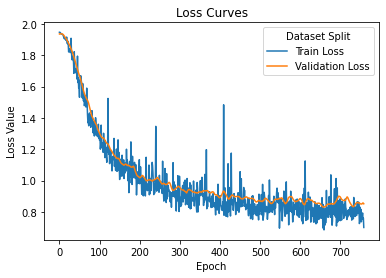

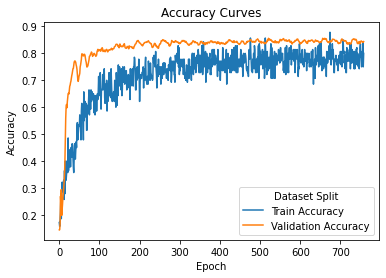

759


In [5]:
def plot_loss_curves(train_losses, val_losses):
    assert len(train_losses) == len(val_losses), "Inconsistent plotting sizes."
    
    time = list(range(epoch))
    visual_df = pd.DataFrame({
        "Train Loss": train_losses,
        "Validation Loss": val_losses,
        "Epoch": time
    })

    sns.lineplot(x='Epoch', y='Loss Value', hue='Dataset Split', data=pd.melt(visual_df, ['Epoch'], value_name="Loss Value", var_name="Dataset Split"))
    plt.title("Loss Curves")
    plt.show()

def plot_accuracy_curves(train_acc, val_acc):
    assert len(train_acc) == len(val_acc), "Inconsistent plotting sizes."
    
    time = list(range(epoch))
    visual_df = pd.DataFrame({
        "Train Accuracy": train_acc,
        "Validation Accuracy": val_acc,
        "Epoch": time
    })

    sns.lineplot(x='Epoch', y='Accuracy', hue='Dataset Split', data=pd.melt(visual_df, ['Epoch'], value_name="Accuracy", var_name="Dataset Split"))
    plt.title("Accuracy Curves")
    plt.show()

plot_loss_curves(train_losses, val_losses)
plot_accuracy_curves(train_acc, val_acc)
print(epoch)

In [6]:
from sklearn.manifold import TSNE

def visualize(out, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.title("GCNII")
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    plt.savefig('./GCNII.png',dpi=600)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


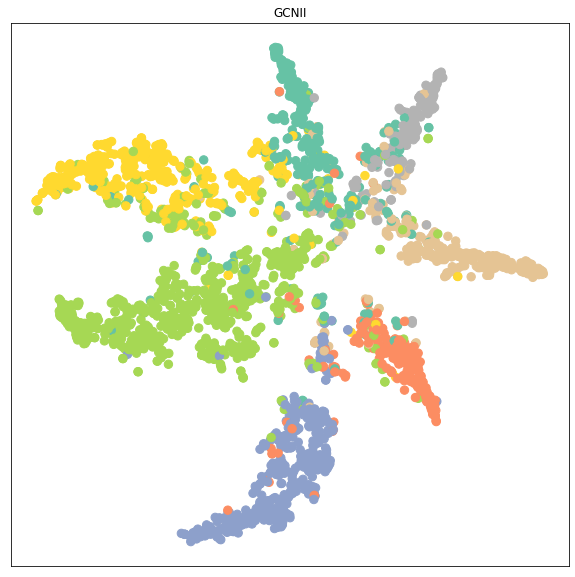

<Figure size 432x288 with 0 Axes>

In [7]:
out = model.forward()
visualize(out, color=data.y.detach().cpu().numpy())